In [17]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Parameters
fs = 1000000       # Sample rate (1 MHz)
fc = 100000        # Carrier freq (100 kHz)
fm = 1000          # Message freq (1 kHz)
t = np.arange(0, 0.01, 1/fs)
message = np.cos(2 * np.pi * fm * t)

# 1. DSB-SC
dsb_sc = message * np.cos(2 * np.pi * fc * t)

# 2. SSB (Upper Sideband)
m_hilbert = hilbert(message)
ssb_usb = np.real(m_hilbert * np.exp(1j * 2 * np.pi * fc * t))

# 3. FM
kf = 50000         # Frequency deviation
integral_m = np.cumsum(message) / fs
fm_signal = np.cos(2 * np.pi * fc * t + 2 * np.pi * kf * integral_m)

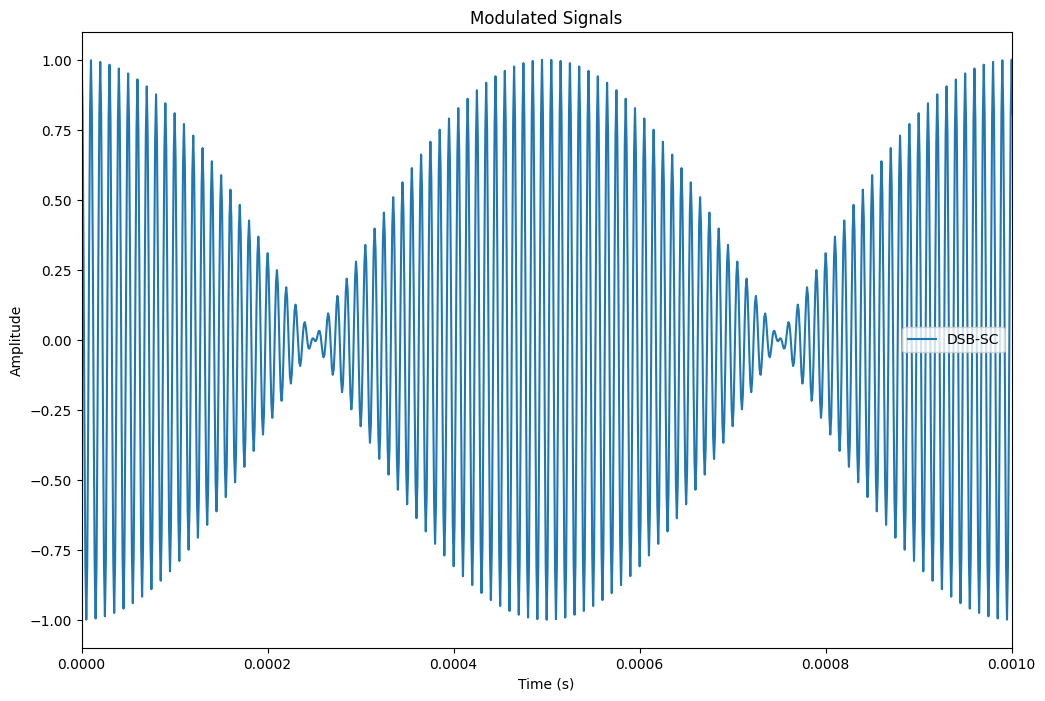

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(t, dsb_sc, label='DSB-SC')
#plt.plot(t, ssb_usb, label='SSB USB')
#plt.plot(t, fm_signal, label='FM')
plt.xlim(0, 0.001)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Modulated Signals')
plt.show()

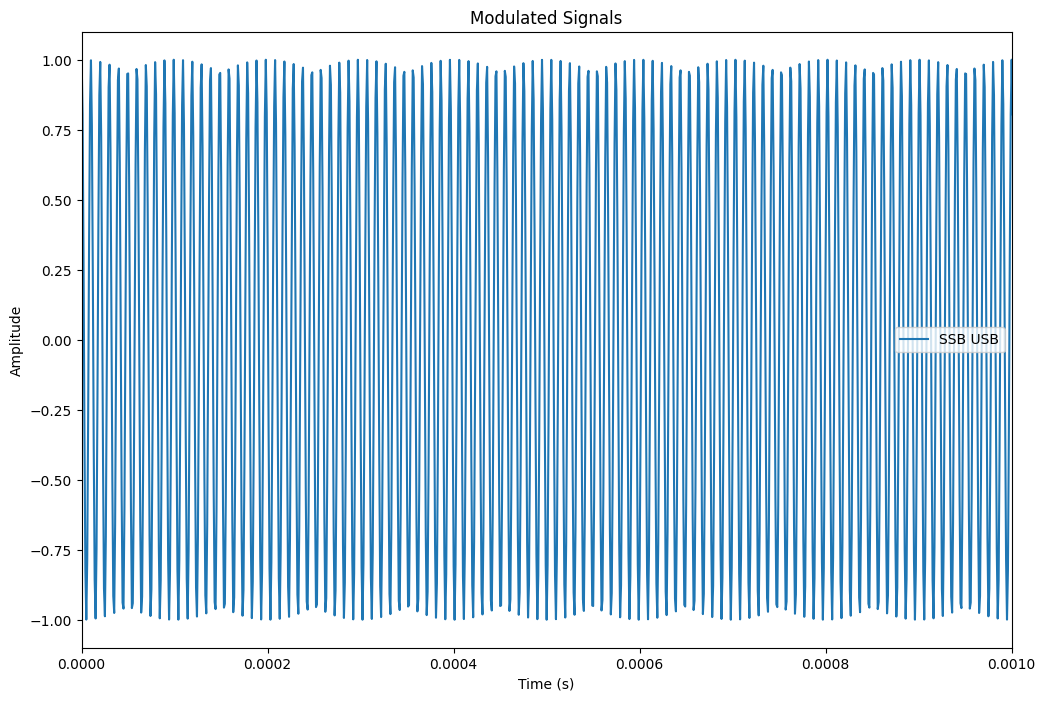

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(t, ssb_usb, label='SSB USB')
#plt.plot(t, fm_signal, label='FM')
plt.xlim(0, 0.001)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Modulated Signals')
plt.show()

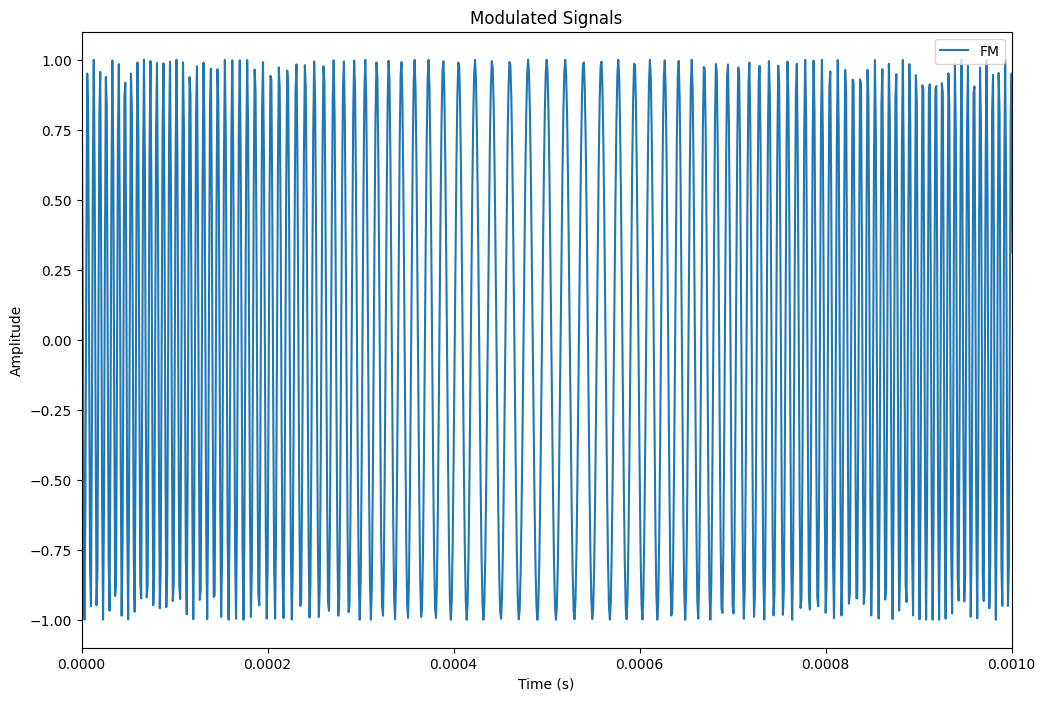

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(t, fm_signal, label='FM')
plt.xlim(0, 0.001)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Modulated Signals')
plt.show()

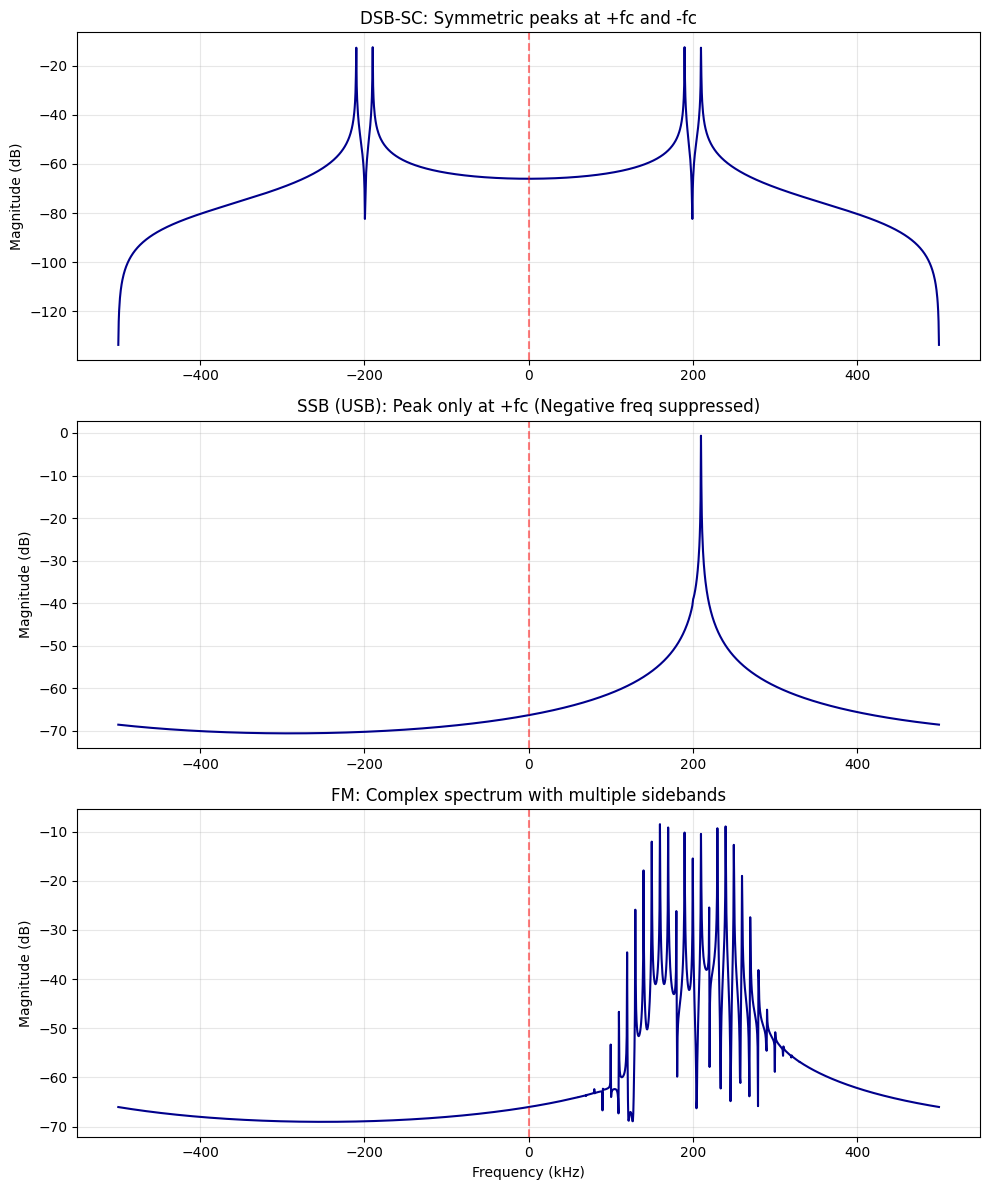

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Parameters
fs = 1000000       # 1 MHz Sample Rate
t = np.arange(0, 0.002, 1/fs) # 2ms duration
fc = 200000        # 200 kHz Carrier
fm = 10000         # 10 kHz Message
message = np.cos(2 * np.pi * fm * t)

# Signal Generation
# DSB-SC (Real)
dsb_sc = message * np.cos(2 * np.pi * fc * t)

# SSB (Complex Baseband representation is common for Pluto)
# Here we use the analytic version to show asymmetry
ssb_usb = hilbert(message) * np.exp(1j * 2 * np.pi * fc * t)

# FM (Complex Exponential form)
kf = 50000
integral_m = np.cumsum(message) / fs
fm_signal = np.exp(1j * (2 * np.pi * fc * t + 2 * np.pi * kf * integral_m))

def plot_complex_spectrum(signal, title, pos):
    plt.subplot(3, 1, pos)
    
    # Compute FFT and shift
    n = len(signal)
    fft_val = np.fft.fftshift(np.fft.fft(signal)) / n
    freqs = np.fft.fftshift(np.fft.fftfreq(n, 1/fs))
    
    # Convert to dB for visibility
    psd = 20 * np.log10(np.abs(fft_val) + 1e-10) 
    
    plt.plot(freqs / 1e3, psd, color='darkblue')
    plt.title(title)
    plt.ylabel('Magnitude (dB)')
    plt.grid(True, alpha=0.3)
    plt.axvline(0, color='red', linestyle='--', alpha=0.5) # Zero frequency marker

plt.figure(figsize=(10, 12))
plot_complex_spectrum(dsb_sc, "DSB-SC: Symmetric peaks at +fc and -fc", 1)
plot_complex_spectrum(ssb_usb, "SSB (USB): Peak only at +fc (Negative freq suppressed)", 2)
plot_complex_spectrum(fm_signal, "FM: Complex spectrum with multiple sidebands", 3)
plt.xlabel('Frequency (kHz)')
plt.tight_layout()
plt.show()

In [22]:
def add_awgn_noise(signal, target_snr_db):
    # 1. Calculate signal power 
    # Power = Mean of the squared absolute values
    sig_power = np.mean(np.abs(signal)**2)
    sig_power_db = 10 * np.log10(sig_power)
    
    # 2. Calculate required noise power in dB
    noise_power_db = sig_power_db - target_snr_db
    noise_power_linear = 10**(noise_power_db / 10)
    
    # 3. Generate white noise
    # For RF/Complex signals, noise is usually complex
    # For real-only simulation, use: np.random.normal(0, np.sqrt(noise_power_linear), len(signal))
    noise = np.random.normal(0, np.sqrt(noise_power_linear), len(signal))
    
    return signal + noise

# Usage:
snr_to_test = 50 # 10dB is a moderate noise level
noisy_dsb_sc = add_awgn_noise(dsb_sc, snr_to_test)
noisy_fm = add_awgn_noise(fm_signal, snr_to_test)
noisy_ssb = add_awgn_noise(ssb_usb, snr_to_test)

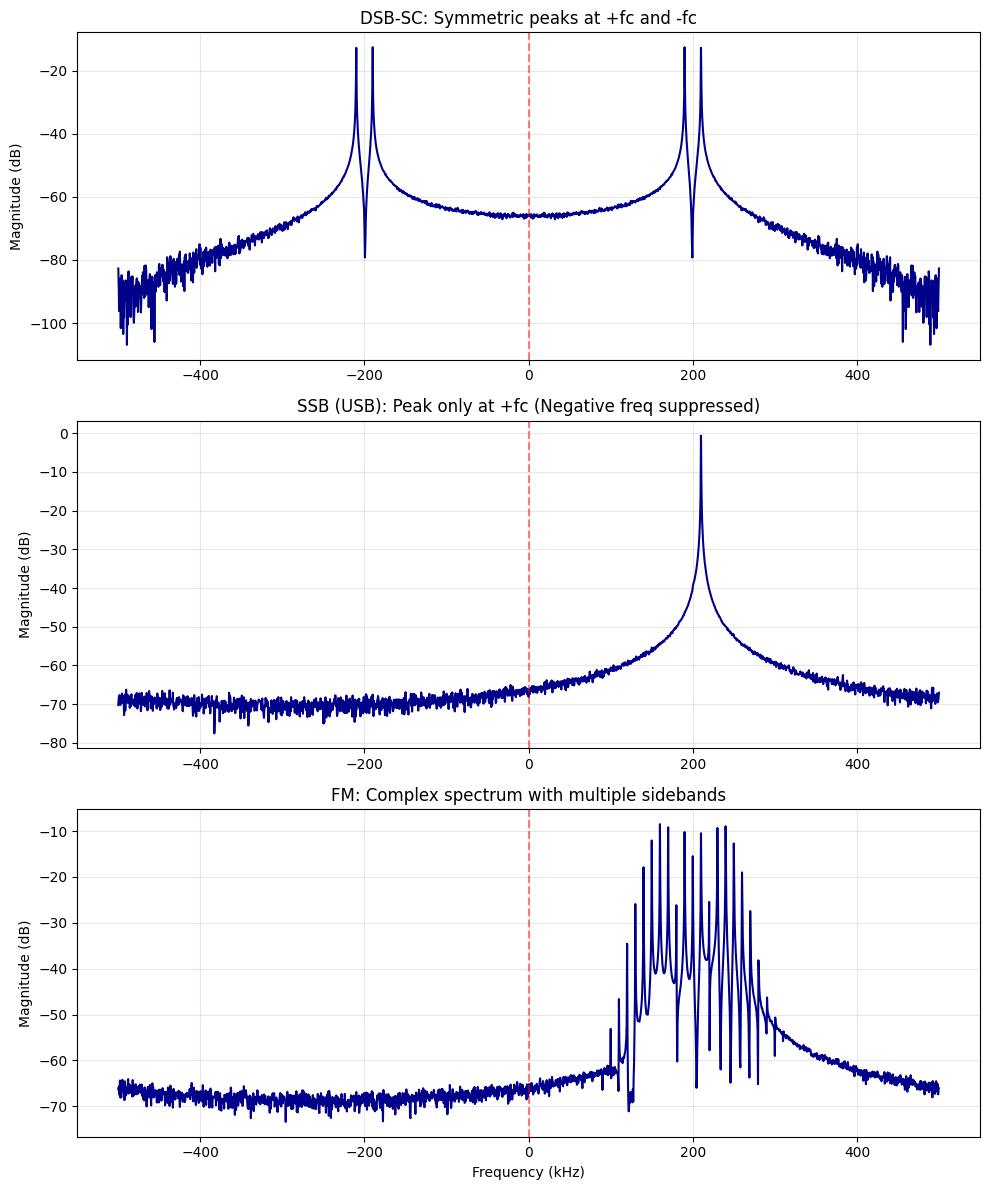

In [23]:
plt.figure(figsize=(10, 12))
plot_complex_spectrum(noisy_dsb_sc, "DSB-SC: Symmetric peaks at +fc and -fc", 1)
plot_complex_spectrum(noisy_ssb, "SSB (USB): Peak only at +fc (Negative freq suppressed)", 2)
plot_complex_spectrum(noisy_fm, "FM: Complex spectrum with multiple sidebands", 3)
plt.xlabel('Frequency (kHz)')
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
from scipy.signal import hilbert

def classify_signal(signal, fs, fc):
    """
    Classifies a signal as FM, DSB-SC, or SSB.
    """
    # 1. Extract Instantaneous Amplitude (Envelope)
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    
    # Normalize amplitude and calculate variance
    normalized_env = amplitude_envelope / np.mean(amplitude_envelope)
    amplitude_variance = np.var(normalized_env)
    
    # 2. Extract Spectral Symmetry
    # Perform FFT and shift to center at DC
    fft_vals = np.fft.fftshift(np.fft.fft(signal))
    freqs = np.fft.fftshift(np.fft.fftfreq(len(signal), 1/fs))
    
    # Isolate USB and LSB relative to carrier fc
    usb_mask = (freqs > fc) & (freqs < fc + (fs/4))
    lsb_mask = (freqs < fc) & (freqs > fc - (fs/4))
    
    p_usb = np.sum(np.abs(fft_vals[usb_mask])**2)
    p_lsb = np.sum(np.abs(fft_vals[lsb_mask])**2)
    
    symmetry_index = abs(p_usb - p_lsb) / (p_usb + p_lsb)

    # 3. Decision Logic
    # Thresholds may need tuning based on your noise levels
    if amplitude_variance < 0.05:
        return "FM"
    else:
        if symmetry_index > 0.6: # Significant power imbalance
            return "SSB"
        else:
            return "DSB-SC"

# Example usage with the signals we generated earlier:
print(f"Detected Type: {classify_signal(noisy_fm, fs, fc)}")
print(f"Detected Type: {classify_signal(dsb_sc, fs, fc)}")
print(f"Detected Type: {classify_signal(ssb_usb, fs, fc)}")

ValueError: x must be real.